In [159]:
from dotenv import load_dotenv
import os
load_dotenv()
API_KEY = os.environ.get("API_KEY")
SECRET_KEY = os.environ.get("SECRET_KEY")


In [160]:
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [161]:

# Create the client
client = StockHistoricalDataClient(API_KEY, SECRET_KEY)

# Define date range
end_date = datetime.now()
start_date = end_date - timedelta(days= 252)  

# Create request for NVDA
request = StockBarsRequest(
    symbol_or_symbols=["NVDA", "AMD"],
    timeframe=TimeFrame.Day,
    start=start_date,
    end=end_date
)


# Fetch data
bars = client.get_stock_bars(request)

# # Convert to DataFrames
df = bars.df.reset_index()
df = df.pivot(index="timestamp", columns="symbol", values="close")
print(df)


symbol                        AMD    NVDA
timestamp                                
2024-12-04 05:00:00+00:00  143.99  145.14
2024-12-05 05:00:00+00:00  141.36  145.06
2024-12-06 05:00:00+00:00  138.59  142.44
2024-12-09 05:00:00+00:00  130.87  138.81
2024-12-10 05:00:00+00:00  127.74  135.07
...                           ...     ...
2025-08-06 04:00:00+00:00  163.12  179.42
2025-08-07 04:00:00+00:00  172.40  180.77
2025-08-08 04:00:00+00:00  172.76  182.70
2025-08-11 04:00:00+00:00  172.28  182.06
2025-08-12 04:00:00+00:00  174.95  183.16

[171 rows x 2 columns]


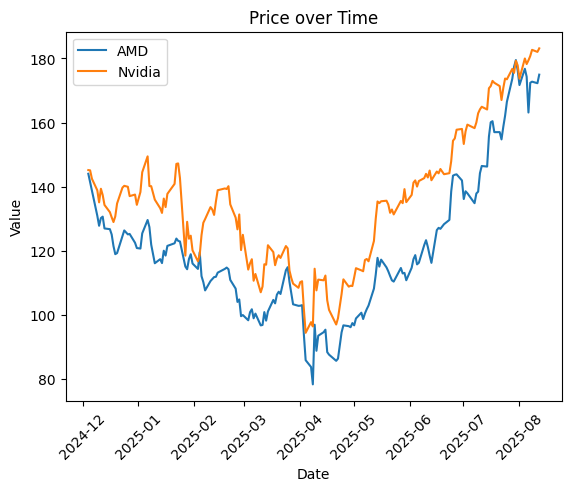

In [162]:
plt.plot(df.index, df['AMD'], label='AMD')
plt.plot(df.index, df['NVDA'], label='Nvidia')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Price over Time')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [163]:
print(df.corr())

symbol       AMD      NVDA
symbol                    
AMD     1.000000  0.956331
NVDA    0.956331  1.000000


In [164]:
# Since assets can be highly correlated and still diverge, we will use a stronger statistical measure, called cointegration
import statsmodels.tsa.stattools as ts 
result = ts.coint(df['AMD'], df['NVDA'])
p_val = result[1]
if p_val < 0.05:
    print(f"With a p value of {round(p_val,4)}, we can reject the null hypothesis and conclude the assets are cointegrated.")
else:
    print(f"With a p value of {round(p_val,4)}, we cannot reject the null hypothesis and conclude the assets are not cointegrated.")



With a p value of 0.0141, we can reject the null hypothesis and conclude the assets are cointegrated.


In [165]:
# Next we will calculate the spread using OLS
import statsmodels.api as sm
# Step 1: Define dependent and independent variables
Y = df['NVDA']
X = df['AMD']

# Step 2: Add constant term for regression
X = sm.add_constant(X)

# Step 3: Run OLS regression
model = sm.OLS(Y, X).fit()

# Step 4: Hedge ratio is the slope (coefficient on AMD)
hedge_ratio = model.params['AMD']

print(f"Hedge Ratio: {hedge_ratio}")

# Step 5: Compute the spread
spread = df['NVDA'] - hedge_ratio * df['AMD']


Hedge Ratio: 0.9090533259178073


In [166]:
# In order to work with means that aren't meaningless, we must determine whether our spread is stationary or not
from statsmodels.tsa.stattools import adfuller

result = adfuller(spread)
p_val = result[1]
if p_val < 0.05:
    print(f"With a p value of {round(p_val,4)}, we can reject the null hypothesis and conclude the spread is likely stationary.")
else:
    print(f"With a p value of {round(p_val,4)}, we cannot reject the null hypothesis and conclude the spread is likely not stationary.")


With a p value of 0.0025, we can reject the null hypothesis and conclude the spread is likely stationary.


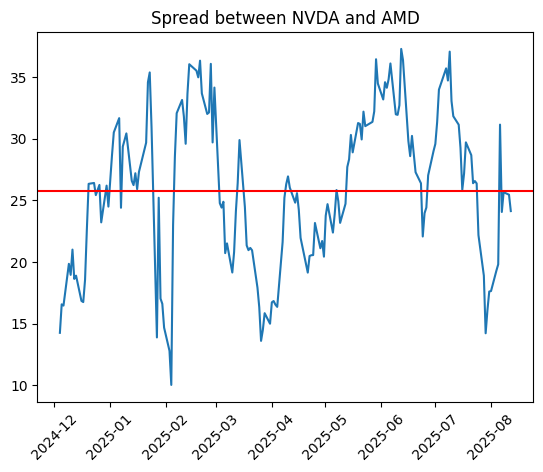

In [167]:

plt.plot(df.index, spread, label = 'Spread (NVDA - AMD)')
plt.axhline(spread.mean(), color='red')
plt.title("Spread between NVDA and AMD")
plt.xticks(rotation=45)
plt.show()

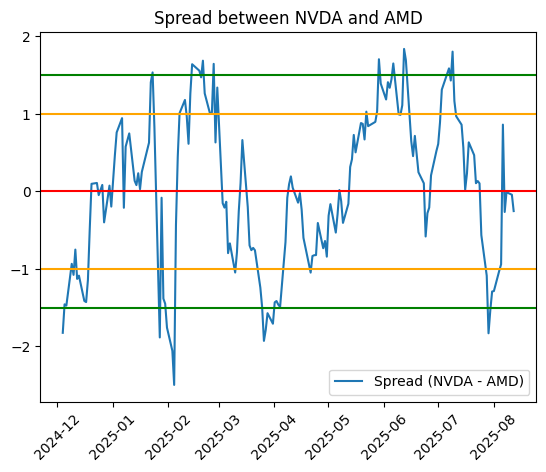

In [168]:
# Next, we will standardize the spread so that the mean is 0 and the standard deviation is 1
# As we can see, if the spread deviates past 1 standard deviation from the mean, it is likely to soon revert back to the mean
spread_normalized = (spread - spread.mean()) / spread.std()
plt.plot(df.index, spread_normalized, label = 'Spread (NVDA - AMD)')
plt.axhline(1, color='orange')
plt.axhline(1.5, color='green')

plt.axhline(0, color='red')
plt.axhline(-1, color='orange')
plt.axhline(-1.5, color='green')
plt.title("Spread between NVDA and AMD")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [169]:
#smooth the spread over last 5 days average
spread_5_mean = spread.rolling(5).mean()
#since we can't know the future means and stds, we will use the last 60 days
spread_60_mean = spread.rolling(60).mean()
spread_60_std = spread.rolling(60).std()
z_score_60_5 = (spread_5_mean - spread_60_mean) / spread_60_std


# plt.plot(df.index, z_score_60_5, label = 'Spread Rolling')
# plt.plot(df.index, spread_normalized, label = 'Spread All')
# plt.legend()
# plt.xticks(rotation=45)
# plt.show()

                             zscore  longs  shorts  exits  position
timestamp                                                          
2025-03-04 05:00:00+00:00  0.576887  False   False  False       0.0
2025-03-05 05:00:00+00:00  0.235420  False   False   True       0.0
2025-03-06 05:00:00+00:00 -0.039635  False   False   True       0.0
2025-03-07 05:00:00+00:00 -0.434481  False   False  False       0.0
2025-03-10 04:00:00+00:00 -0.601471  False   False  False       0.0
...                             ...    ...     ...    ...       ...
2025-08-06 04:00:00+00:00 -1.427912  False   False  False       1.0
2025-08-07 04:00:00+00:00 -1.189182  False   False  False       1.0
2025-08-08 04:00:00+00:00 -0.889706  False   False  False       1.0
2025-08-11 04:00:00+00:00 -0.656225  False   False  False       1.0
2025-08-12 04:00:00+00:00 -0.479188  False   False  False       1.0

[112 rows x 5 columns]


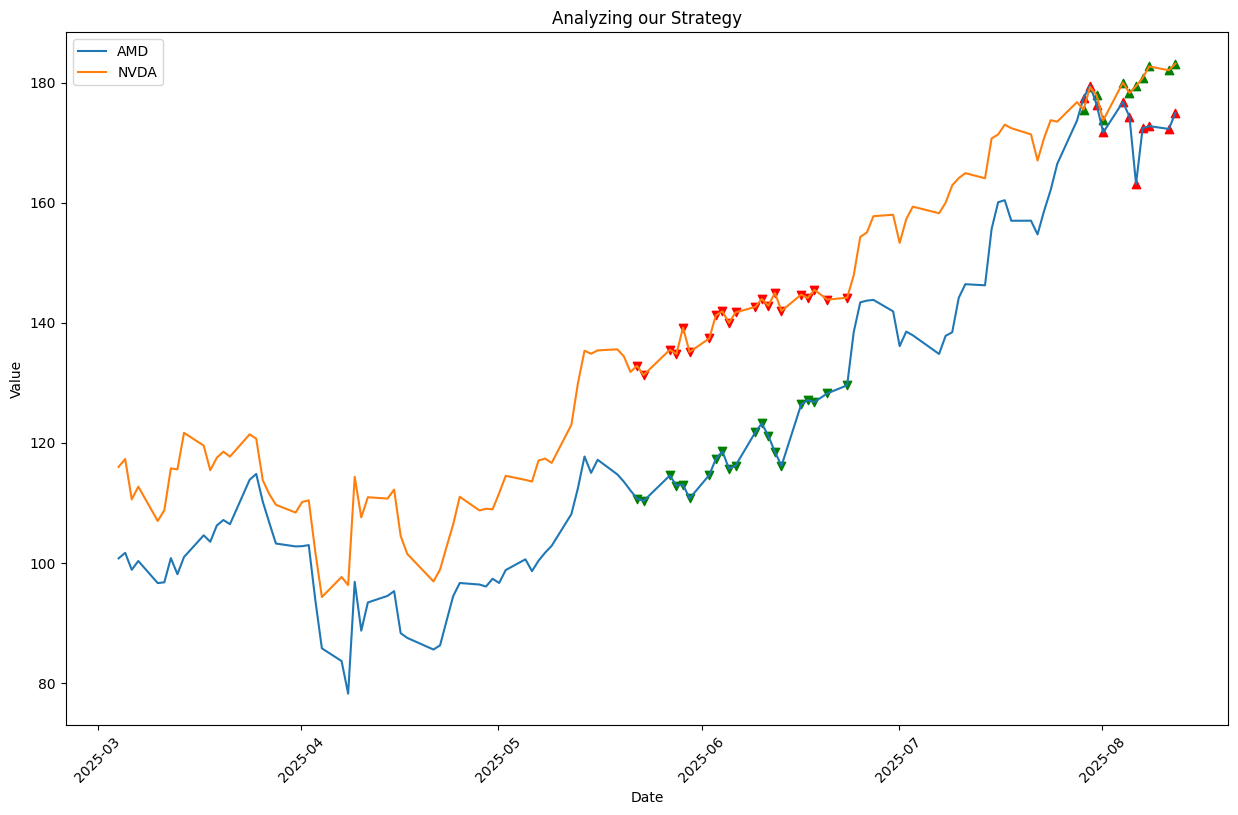

In [170]:
trades = pd.DataFrame(z_score_60_5, columns=['zscore'])
trades = trades[trades['zscore'].notnull()]
# spread = pd.DataFrame(spread, columns=['spread'])
trades['longs'] = trades['zscore'] < -1.5
trades['shorts'] = trades['zscore'] > 1.5
trades['exits'] = abs(trades['zscore']) < 0.3

trades['position'] = np.nan
trades.loc[trades['longs'], 'position'] = 1
trades.loc[trades['shorts'], 'position'] = -1
trades.loc[trades['exits'], 'position'] = 0
trades['position'] = trades['position'].ffill().fillna(0)
print(trades)

trades = pd.merge(trades, df, how = 'left', left_index=True, right_index=True)

longs = trades[trades['position'] == 1]
shorts = trades[trades['position'] == -1]
# trades = pd.merge(spread, trades, left_index=True, right_index=True)
# trades['spread_ret'] = trades['spread'].diff()
# trades['pnl'] = trades['position'].shift(1) * trades['spread_ret']
# trades['cum_pnl'] = trades['pnl'].cumsum()

plt.figure(figsize=(15,9))
plt.plot(trades.index, trades['AMD'], label='AMD')
plt.plot(trades.index, trades['NVDA'], label='NVDA')

plt.scatter(longs.index, longs['NVDA'], color='green', marker='^')
plt.scatter(shorts.index, shorts['NVDA'], color='red', marker='v')

plt.scatter(longs.index, longs['AMD'], color='red', marker='^')
plt.scatter(shorts.index, shorts['AMD'], color='green', marker='v')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Analyzing our Strategy')
plt.xticks(rotation=45)
plt.legend()
plt.show()



In [171]:
# Calculate daily returns for each asset
df["amd_ret"] = df["AMD"].pct_change()
df["nvda_ret"] = df["NVDA"].pct_change()


profits = pd.merge(trades, df, how = 'left', left_index=True, right_index=True)


# Notional size (dollars per 1 "unit" of spread position)
notional = 10000  # example: $10k position per side

# PnL from each leg based on position
# When position = 1, you are long NVDA, short 0.9 AMD
# When position = -1, you are short NVDA, long 0.9 AMD
profits["pnl_nvda"] = profits["position"].shift(1) * notional * profits["nvda_ret"]
profits["pnl_amd"] = -hedge_ratio * profits["position"].shift(1) * notional * profits["amd_ret"]

# Total daily PnL in dollars
profits["daily_pnl"] = profits["pnl_nvda"] + profits["pnl_amd"]

# Cumulative PnL
profits["cum_pnl"] = profits["daily_pnl"].cumsum()

print(profits[["zscore", "position", "amd_ret", "nvda_ret", "pnl_nvda", "pnl_amd", "daily_pnl", "cum_pnl"]])

                             zscore  position   amd_ret  nvda_ret    pnl_nvda  \
timestamp                                                                       
2025-03-04 05:00:00+00:00  0.576887       0.0  0.025654  0.016921         NaN   
2025-03-05 05:00:00+00:00  0.235420       0.0  0.009132  0.011294    0.000000   
2025-03-06 05:00:00+00:00 -0.039635       0.0 -0.027737 -0.057374   -0.000000   
2025-03-07 05:00:00+00:00 -0.434481       0.0  0.014770  0.019173    0.000000   
2025-03-10 04:00:00+00:00 -0.601471       0.0 -0.036686 -0.050670   -0.000000   
...                             ...       ...       ...       ...         ...   
2025-08-06 04:00:00+00:00 -1.427912       1.0 -0.064196  0.006507   65.073488   
2025-08-07 04:00:00+00:00 -1.189182       1.0  0.056891  0.007524   75.242448   
2025-08-08 04:00:00+00:00 -0.889706       1.0  0.002088  0.010677  106.765503   
2025-08-11 04:00:00+00:00 -0.656225       1.0 -0.002778 -0.003503  -35.030104   
2025-08-12 04:00:00+00:00 -0

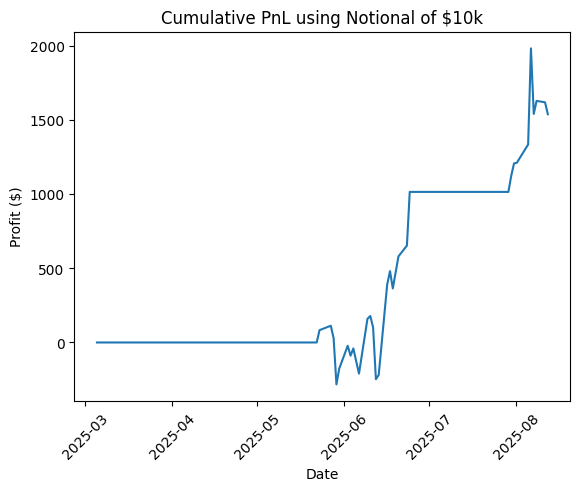

In [172]:
plt.plot(profits.index, profits["cum_pnl"])
plt.xlabel('Date')
plt.ylabel('Profit ($)')
plt.title('Cumulative PnL using Notional of $10k')
plt.xticks(rotation=45)
plt.show()